TASK 1

In [ ]:
pip install pandas


This line imports the pandas library and gives it the alias pd so it can be easily referenced in the code

This loads the Titanic dataset CSV file into a DataFrame called df.
The DataFrame is similar to an Excel table and is a core data structure in pandas for storing tabular datA


In [ ]:
import pandas as pd
df = pd.read_csv("Titanic-Dataset.csv")


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Titanic-Dataset.csv to Titanic-Dataset (1).csv


In [ ]:
print(df.info())
print(df.describe())
print(df.head())
print(df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

Step 2: Handle Missing Values

In [ ]:
import numpy as np

df_clean = df.copy()

# Extract Title from Name
df_clean['Title'] = df_clean['Name'].str.extract(r',\s*([^\.]+)\.')
df_clean['Title'] = df_clean['Title'].str.strip()

# Map rare titles into groups
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady':'Royal', 'Countess':'Royal', 'Dona':'Royal',
    'Capt':'Officer','Col':'Officer','Major':'Officer',
    'Dr':'Officer','Rev':'Officer','Sir':'Royal',
    'Don':'Royal','Jonkheer':'Royal'
}
df_clean['Title'] = df_clean['Title'].replace(title_map)

# Fill missing Age with median per Title
df_clean['Age'] = df_clean.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())

# Fill missing Fare with median
df_clean['Fare'] = df_clean['Fare'].fillna(df_clean['Fare'].median())

# Fill missing Embarked with mode
df_clean['Embarked'] = df_clean['Embarked'].fillna(df_clean['Embarked'].mode()[0])

# Drop Cabin (too many missing)
df_clean = df_clean.drop(columns=['Cabin'])

# Drop Ticket (not useful for prediction)
df_clean = df_clean.drop(columns=['Ticket'])

print("Missing values after cleaning:\n", df_clean.isnull().sum())


Missing values after cleaning:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64


Step 3: Encode Categorical Variables

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode Sex
df_clean['Sex'] = df_clean['Sex'].map({'male':0, 'female':1})

# Encode Title
le = LabelEncoder()
df_clean['Title_enc'] = le.fit_transform(df_clean['Title'])

# One-hot encode Embarked
df_clean = pd.get_dummies(df_clean, columns=['Embarked'], drop_first=True)

print(df_clean.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

      Fare Title  Title_enc  Embarked_Q  Embarked_S  
0   7.2500    Mr          2       False        True  
1  71.2833   Mrs          3       False       False  
2   7.9250  Miss          1       False        True  
3  53.1000   Mrs          3       False        True  
4   8.0500    Mr          

Step 4: Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']

# Standardization (mean=0, std=1)
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# Normalization (range [0,1]) - OPTIONAL
norm = MinMaxScaler()
df_clean[numeric_cols] = norm.fit_transform(df_clean[numeric_cols])

print(df_clean[numeric_cols].head())


        Age      Fare  SibSp  Parch
0  0.271174  0.014151  0.125    0.0
1  0.472229  0.139136  0.125    0.0
2  0.321438  0.015469  0.000    0.0
3  0.434531  0.103644  0.125    0.0
4  0.434531  0.015713  0.000    0.0


Step 5: Outlier Detection (Boxplot)

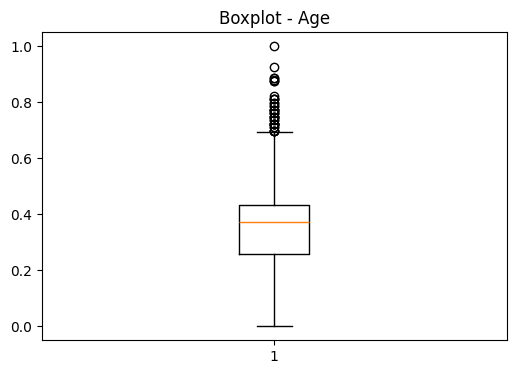

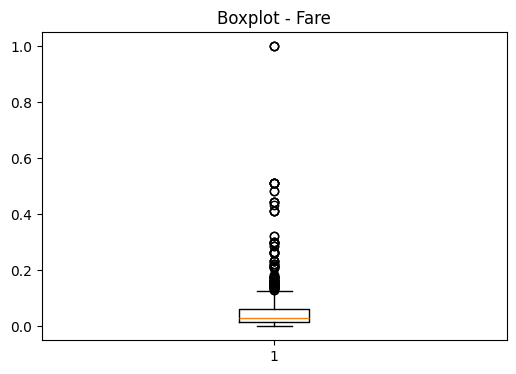

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot(df_clean['Age'])
plt.title("Boxplot - Age")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(df_clean['Fare'])
plt.title("Boxplot - Fare")
plt.show()


Step 6: Outlier Removal (IQR method)

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_no_out = remove_outliers_iqr(df_clean, 'Age')
df_no_out = remove_outliers_iqr(df_no_out, 'Fare')

print("Shape after outlier removal:", df_no_out.shape)


Shape after outlier removal: (744, 13)


Step 7: Save Preprocessed Dataset

In [ ]:
df_no_out.to_csv("titanic_preprocessed.csv", index=False)
print("Saved preprocessed dataset as titanic_preprocessed.csv")


Saved preprocessed dataset as titanic_preprocessed.csv
